## Version History
- 1.0.0 - original tutorial code, with custom dataset (https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)
- 1.0.1 - different code structure to try multivariate and multi-step (https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)

In [27]:
import pandas as pd
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from numpy import array, hstack
import matplotlib.pyplot as plt
import os, math
from keras import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'hydrology_2var.slurm',
 'hydrology_3var.slurm',
 'longwave_radiation_flux.txt',
 'multivariable_hydrology_lstm.py',
 'multivariable_lstm_nasa_1.0.0.py',
 'multivariate_hydrology.txt',
 'multivariate_lstm_nasa_1.0.0.ipynb',
 'nasa_evaporation.h5',
 'nasa_evaporation.slurm',
 'nasa_evaporation_outfile.txt',
 'nasa_evaporation_prediction_201_to_300.txt',
 'nasa_evaporation_prediction_full.txt',
 'nasa_longwave_radiation_laptop.ipynb',
 'nasa_lstm_testmodels.ipynb',
 'nasa_radiation.slurm',
 'nasa_radiation_laptop.h5',
 'nasa_radiation_laptop_outfile.txt',
 'nasa_radiation_prediction_201_to_300.txt',
 'nasa_singlevar_lstm_1.0.0.py',
 'nasa_temperature.slurm',
 'potential_evaporation.txt',
 'temperature.txt']

In [10]:
# Fix random seed for reproducibility
np.random.seed(7)

def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # Finding the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        
        # Checking if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
            
        # Gather input and output parts of pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix: out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

def load_col(txtfile, col, process):
    dataset = pd.read_csv(txtfile, sep='\t',
                               header=None,usecols=[col])
    if process==True:
        #dataset = dataset.values[2:]
        dataset = dataset.astype('float32')
        scaler = MinMaxScaler(feature_range=(0,1))
        dataset = scaler.fit_transform(dataset)
        return dataset, scaler
    elif process==False:
        return dataset

In [11]:
evaporation_array, evaporation_scaler = load_col("potential_evaporation.txt", 0, True)
radiation_array, radiation_scaler = load_col("longwave_radiation_flux.txt", 0, True)

In [13]:
print(evaporation_array)
print(radiation_array)

[[0.12554154]
 [0.06161548]
 [0.06161548]
 ...
 [0.73707515]
 [0.5179551 ]
 [0.5179551 ]]
[[0.2711626 ]
 [0.2711626 ]
 [0.27119455]
 ...
 [0.92040443]
 [0.92040443]
 [0.92040443]]


In [14]:
full_dataset_scaled = hstack((evaporation_array, radiation_array))

In [36]:
n_steps_in = 100
n_steps_out = 100
X, y = split_sequence(full_dataset_scaled, n_steps_in, n_steps_out)
n_features = X.shape[2]

print(X.shape, y.shape)

es = EarlyStopping(patience=4, monitor='loss')
mc = ModelCheckpoint("chkp/model.hdf5", monitor='loss', save_best_only=True, mode='min')

(3905, 100, 2) (3905, 100, 2)


In [37]:
# define model
model = Sequential()
model.add(LSTM(n_steps_in, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(n_steps_in, activation='relu', return_sequences=True))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')

In [38]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100, 100)          41200     
_________________________________________________________________
lstm_10 (LSTM)               (None, 100, 100)          80400     
_________________________________________________________________
dense_5 (Dense)              (None, 100, 2)            202       
Total params: 121,802
Trainable params: 121,802
Non-trainable params: 0
_________________________________________________________________


In [41]:
# fit model
history = model.fit(X, y, epochs=50, verbose=1, callbacks=[es, mc], batch_size=128)

Epoch 1/50
3905/3905 [==============================] - 26s 7ms/step - loss: 0.0171
Epoch 2/50
3905/3905 [==============================] - 26s 7ms/step - loss: 0.0171
Epoch 3/50
3905/3905 [==============================] - 26s 7ms/step - loss: 0.0170
Epoch 4/50
3905/3905 [==============================] - 26s 7ms/step - loss: 0.0169
Epoch 5/50
3905/3905 [==============================] - 26s 7ms/step - loss: 0.0169
Epoch 6/50
3905/3905 [==============================] - 26s 7ms/step - loss: 0.0169
Epoch 7/50
3905/3905 [==============================] - 26s 7ms/step - loss: 0.0168
Epoch 8/50
3905/3905 [==============================] - 26s 7ms/step - loss: 0.0168
Epoch 9/50
3905/3905 [==============================] - 26s 7ms/step - loss: 0.0167
Epoch 10/50
3905/3905 [==============================] - 26s 7ms/step - loss: 0.0167
Epoch 11/50
3905/3905 [==============================] - 26s 7ms/step - loss: 0.0167
Epoch 12/50
3905/3905 [==============================] - 26s 7ms/step - lo

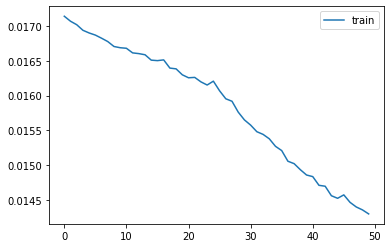

In [42]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

In [43]:
# make a prediction
yhat = model.predict(X)

In [44]:
print(yhat)

[[[0.08747137 0.2751452 ]
  [0.1418506  0.3617277 ]
  [0.16632523 0.4080816 ]
  ...
  [0.04112604 0.25336096]
  [0.04828306 0.24764135]
  [0.05920977 0.24232736]]

 [[0.07519403 0.25674474]
  [0.13840088 0.3526021 ]
  [0.17869635 0.41077137]
  ...
  [0.04832432 0.24755982]
  [0.0592512  0.24223384]
  [0.0692502  0.23596156]]

 [[0.07519563 0.25674736]
  [0.13780673 0.351846  ]
  [0.1772807  0.4093544 ]
  ...
  [0.05881758 0.2400811 ]
  [0.06886611 0.2337552 ]
  [0.07584506 0.22736639]]

 ...

 [[0.21281444 0.46446583]
  [0.32685038 0.62031394]
  [0.43977076 0.7506523 ]
  ...
  [0.9192605  0.88425314]
  [0.99204654 0.93300927]
  [0.8943236  0.9410725 ]]

 [[0.22508793 0.4849002 ]
  [0.49481034 0.7751776 ]
  [0.5056363  0.82055795]
  ...
  [0.99303794 0.933391  ]
  [0.896058   0.94182825]
  [0.7140355  0.9267424 ]]

 [[0.38651368 0.71109813]
  [0.4714879  0.8074022 ]
  [0.32782868 0.7608998 ]
  ...
  [0.90737176 0.9480803 ]
  [0.7288321  0.93431884]
  [0.59368795 0.93580824]]]


In [48]:
print(yhat.shape)

(3905, 100, 2)


In [61]:
yhat_evaporation = []
for i in range(len(yhat)):
    vector = []
    for j in range(yhat.shape[1]):
        vector.append(yhat[i][j][0])
    yhat_evaporation.append(vector)
    
yhat_radiation = []
for i in range(len(yhat)):
    vector = []
    for j in range(yhat.shape[1]):
        vector.append(yhat[i][j][1])
    yhat_radiation.append(vector)

In [83]:
print(np.shape(yhat_evaporation))

(3905, 100)


In [65]:
yhat_evaporation_201 = yhat_evaporation[201]
yhat_radiation_201 = yhat_radiation[201]
yhat_evaporation_201 = np.reshape(yhat_evaporation_201, (-1,1))
yhat_radiation_201 = np.reshape(yhat_radiation_201, (-1,1))

In [67]:
inv_yhat_evaporation_201 = evaporation_scaler.inverse_transform(yhat_evaporation_201)
inv_yhat_radiation_201 = radiation_scaler.inverse_transform(yhat_radiation_201)

In [70]:
inv_yhat_201 = hstack((inv_yhat_evaporation_201, inv_yhat_radiation_201))

In [114]:
outputfilename = "nasa_multivariable_prediction_201_to_300.txt"

output_file = open(outputfilename, "w")

print("Opened txt file")

for i in range(len(inv_yhat_201)):
    #print(i, end='\r')
    entry = str(inv_yhat_201[i][0]) + "\t" + str(inv_yhat_201[i][1]) + "\n"
    output_file.write(entry)

print("Closed txt file")

Opened txt file
Closed txt file


In [106]:
inv_yhat_1 = []
for i in range(len(full_dataset_scaled) - n_steps_in - n_steps_out + 1):
    array = []
    inv_evap = evaporation_scaler.inverse_transform(np.reshape(yhat_evaporation[i], (-1,1)))
    array.append(inv_evap[0][0])
    inv_radi = radiation_scaler.inverse_transform(np.reshape(yhat_radiation[i], (-1,1)))
    array.append(inv_radi[0][0])
    inv_yhat_1.append(array)
#yhat_1 = np.reshape(yhat_1, (-1,1))
#inv_yhat_1 = data_scaler.inverse_transform(yhat_1)

In [112]:
print(inv_yhat_1[0][1])

237.3749


In [116]:
outputfilename = "nasa_multivariable_prediction_full.txt"

output_file = open(outputfilename, "w")

print("Opened txt file")

for i in range(len(inv_yhat_1)):
    #print(i, end='\r')
    entry = str(inv_yhat_1[i][0]) + "\t" + str(inv_yhat_1[i][1]) + "\n"
    output_file.write(entry)

print("Closed txt file")

Opened txt file
Closed txt file
